<img src = "COuv.png" width=300px>


In [32]:
import pickle
import os
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

#Package used for cleaning data
import re
from stop_words import get_stop_words
from nltk.stem.snowball import FrenchStemmer

#Package used for the plots
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

#Package used for the benchmark
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import cross_validation as cv
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV

#Package for evaluating
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

class ProjectFDC:
    
    def __init__(self, my_dict):
        
        """
        input : my_dict --> (dict)
                format : {id :
                                {date1 :
                                            [ [words in left window], [words in right window], count of date,  
                                               relevant_date]
                                  }
                                {date2 :
                                            [ [words in left window], [words in right window], count of date,  
                                               relevant_date]
                                  }
        """
        
        self.my_dict = my_dict
        self.word_left = []
        self.word_right = []
        self.word_left_right = []
        self.target = []
        self.count = []
        
        self.count_vect = None
        self.tf_transformer = None
        self.tfidf_transformer = None
        
        self.freqs = None
        self.X_counts_train = None
        self.X_freq_train = None
        self.X_tfidf_train = None
        self.X_counts_test = None
        self.X_freq_test = None
        self.X_tfidf_test = None
        self.text = []
        self.count_train = []
        self.count_test = []
        self.train_data = []
        self.test_data = []
        self.train_target = []
        self.test_target = []
        

    def cleanData(self, stem = True) : 
        
        """
            Parameter : stem --> (Boolean) True for stemming words (french)
                                           False for don't 
            
            1/ delete accents
            2/ keep only basics alpha-numeric
            3/ delete double space
            4/ remove capital letter to 
        """
        

        file_object = self.my_dict
        t = time()
        stemmer = FrenchStemmer()
        for id, multi_dates in file_object.items():
            
            for date, date_features in multi_dates.items():
                
                self.count = self.count + [date_features[2]]
                
                #Cleaning left sentences
                list_left = date_features[0]
                list_left = ' '.join(list_left)
                list_left = re.sub(r"[éèê]","e",list_left)
                list_left = re.sub(r"[^A-Za-z]"," ", list_left)
                list_left = re.sub(r"\s{2,}"," ",list_left)
                list_left = list_left.lower()
                list_left = list_left.strip().lower()
                if stem == True:
                    list_left = stemmer.stem(list_left)
                    
                    
                
                #Cleaning right sentences
                list_right = date_features[1]
                list_right = ' '.join(list_right)
                list_right = re.sub(r"[éèê]","e",list_right)
                list_right = re.sub(r"[^A-Za-z]"," ", list_right)
                list_right = re.sub(r"\s{2,}"," ",list_right)
                list_right = list_right.lower()
                list_right = list_right.strip().lower()
                if stem == True:
                    list_right = stemmer.stem(list_right)
                
                self.word_left = self.word_left + [list_left]
                self.word_right = self.word_right + [list_right]  
                self.word_left_right = self.word_left_right + [' '.join([list_left]+[list_right])]
                
                
                if date_features[3] == True : 
                    self.target = self.target + [True]
                    
                else : 
                    self.target = self.target + [False]
        clean_time = time() - t
        print("Cleaning time:  %0.3fs" % clean_time)
                    
                    
    def trainTest(self, perc, set_data, subsample = False) :
        
        """
        Separate data in two part train & test
        
        perc --> (float) percentage used for separate
        
        set_data --> (int) for choose data used for the folow-up
                      1 : left data
                      2 : right data
                      3 : left & right data
                      
        subsample --> (boolean) True for using subsample data for training
        """
        
        data = []
        if set_data == 1:
            data = self.word_left
        elif set_data == 2:
            data = self.word_right
        else:
            data = self.word_left_right 
            self.train_data, self.test_data, self.train_target, self.test_target = cv.train_test_split(data, self.target, test_size = perc, random_state = 1234)
            self.count_train, self.count_test, self.train_target_1, self.test_target_1 = cv.train_test_split(self.count, self.target, test_size = perc, random_state = 1234)
        
        if subsample == True:
            data = pd.DataFrame(test.train_target)
            nbr = len(self.train_target) - sum(self.train_target*1)
            irelevant_indices = data[data == False].index
            random_indices = np.random.choice(irelevant_indices, nbr, replace=False)
            irelevant_sample = data.loc[random_indices]
            sample_size = sum(test.train_target*1)
            random_indices = np.random.choice(irelevant_indices, sample_size, replace=False)
            indice_train = sorted(sorted(random_indices) +  list(np.where(data == True)[0]))
            self.train_data = [self.train_data[i] for i in indice_train]
            self.train_target = [self.train_target[i] for i in indice_train]
    
    def termMatrix(self, stop_words, freq = None, nbr=100) :
        
        """
        Input : stop_words --> (boolean) True stop word use
                                         False no stop word use
                nbr --> (int) number of word (sort from largest to smallest) used for create doc term matrix 
                freq --> list of decreasing important word
        return : X_counts --> Bag Of Word
                 X_freq --> Term Frequency
                 X_tfidf --> Inverse Term Frequency
        """
        t = time()

        if stop_words == True:
            stop_w = get_stop_words('fr')
            self.count_vect = CountVectorizer(stop_words = stop_w)
        else : 
            self.count_vect = CountVectorizer()
        if freq == None:
            # Bag of Word
            self.X_counts_train = self.count_vect.fit_transform(self.train_data)
            freqs = [(word, self.X_counts_train.getcol(idx).sum()) for word, idx in self.count_vect.vocabulary_.items()]
            freqs = sorted (freqs, key = lambda x: -x[1])
            texte = []
            for lists in freqs[:nbr]:    
                texte = texte + [lists[0]]
            self.count_vect.fit(texte)
            self.X_counts_train = self.count_vect.transform(self.train_data)
            self.X_counts_test = self.count_vect.transform(self.test_data)

        else:
            # Bag of Word
            self.X_counts_train = self.count_vect.fit_transform(self.train_data)
            texte = []
            for lists in freq[:nbr]:    
                texte = texte + [lists[0]]
            self.count_vect.fit(texte)
            self.X_counts_train = self.count_vect.transform(self.train_data)
            self.X_counts_test = self.count_vect.transform(self.test_data)

        # Term Frequency
        tf_transformer = TfidfTransformer(use_idf=False)
        self.X_freq_train = tf_transformer.fit_transform(self.X_counts_train)
        self.X_freq_test = tf_transformer.transform(self.X_counts_test)

        # Inverse Term Frequency
        tfidf_transformer = TfidfTransformer()
        self.X_tfidf_train = tfidf_transformer.fit_transform(self.X_counts_train)
        self.X_tfidf_test = tfidf_transformer.transform(self.X_counts_test)
            
            
        create_tm = time() - t
        print("Create term matrix :  %0.3fs" % create_tm)
        
        
    def visualisation(self, data , target):
        """
        # SVD Représentation (3D)
        # Importance of words (random forest used for that)
        
        Input : data(matrix) used(list) & its target
        """
        t = time()
        cdict = {'red':   ((0.0, 0.0, 0.0),
                           (0.5, 0.0, 0.0),
                           (1.0, 1.0, 1.0)),
                 'blue':  ((0.0, 0.0, 0.0),
                           (1.0, 0.0, 0.0)),
                 'green': ((0.0, 0.0, 1.0),
                           (0.5, 0.0, 0.0),
                           (1.0, 0.0, 0.0))}

        cmap = mcolors.LinearSegmentedColormap('my_colormap', cdict, 100)
        
        #SVD Representation
        
        X = data
        y = target

        fig = plt.figure(1, figsize=(10, 8))
        plt.clf()
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

        plt.cla()
        svd = decomposition.TruncatedSVD(n_components=3)
        svd.fit(X)
        X = svd.transform(X)

        # Percentage of variance explained for each components
        print('explained variance ratio (first three components): %s'% str(svd.explained_variance_ratio_))
        plt.figure()
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=cmap, edgecolor='k')
        plt.show()
        
        
        #1000 more important words 
        rfc = RandomForestClassifier(n_estimators=10)
        rfc.fit(self.X_freq_train, self.train_target)
        freqs = sorted([(word,rfc.feature_importances_[idx]) for word, idx in self.count_vect.vocabulary_.items()], key = lambda x: -x[1])
        self.freqs = freqs
        print(freqs[:100])
        
        visu = time() - t
        print("Visualise time :  %0.3fs" % visu)        
        
    def benchmark(self, clf, set_trans):
        
        """
        set_trans --> (int) 1 : Bag Of Word
                            2 : Term Frequency
                            3 : Inverse Term Frequency
        """
        
        train_data = []
        test_data = []
        if set_trans == 1:
            train_data = self.X_counts_train
            test_data = self.X_counts_test
        elif set_trans == 2:
            train_data = self.X_freq_train
            test_data = self.X_freq_test
        else:
            train_data = self.X_tfidf_train
            test_data = self.X_tfidf_test
        
        print('_' * 80)
        print("Training: ")
        print(clf)
        t0 = time()
        clf.fit(train_data, self.train_target)
        train_time = time() - t0
        print("train time: %0.3fs" % train_time)

        t0 = time()
        pred = clf.predict(test_data)
        test_time = time() - t0
        print("test time:  %0.3fs" % test_time)

        score = metrics.accuracy_score(self.test_target, pred)
        print("accuracy:   %0.3f" % score)

        print("classification report:")
        print(metrics.classification_report(self.test_target, pred))

        print("confusion matrix:")
        print(metrics.confusion_matrix(self.test_target, pred))

        print()
        clf_descr = str(clf).split('(')[0]
        
        return clf_descr, score, train_time, test_time
        

### Clean data & Create term Matrix document 
<hr style="border-width:2px;border-color:#3CB371">

#### Cleaning data
* Delete accents
* Keep only basics alpha-numeric
* Delete double space
* Remove capital letter to lower case<br>
__option :__ 

* Stemming 


#### Create term Matrix document
* Using right & left sentences simultaneously
* We used the more important 5000 words (determinate by randomForest algorithme)<br>
__option :__
* delete stop-words (refers to the most common words load here : https://github.com/Alir3z4/python-stop-words)

    * self.X_counts_(train/test) for bag of word
    * self.X_tfidf_(train/test) for Inverse Term Frequency 

$$X[i,j] = TF_{i,j}\times log(\frac{N}{df_j})$$
        * j $TF_{i,j}$ est la fréquence du mot j dans le document i
        * $df_j$ est le nombre de document contenant i
        * $N$ le nombre totale de document
        
    * self.X_freq_(train/test) for Term Frequency
    
    
__Remark :__
Step of cleaning, stop words and selecting 5000 more important words allow to reduce the number of words used for creating dictionnary and reduce significantly overfitting of each models.



#### Visualyze data
For that SVD is used. We plot data transform by first three components
* green for irrelevant date
* red for relevant date


Cleaning time:  114.017s
Create term matrix :  65.155s
explained variance ratio (first three components): [ 0.04665164  0.0330028   0.01937654]


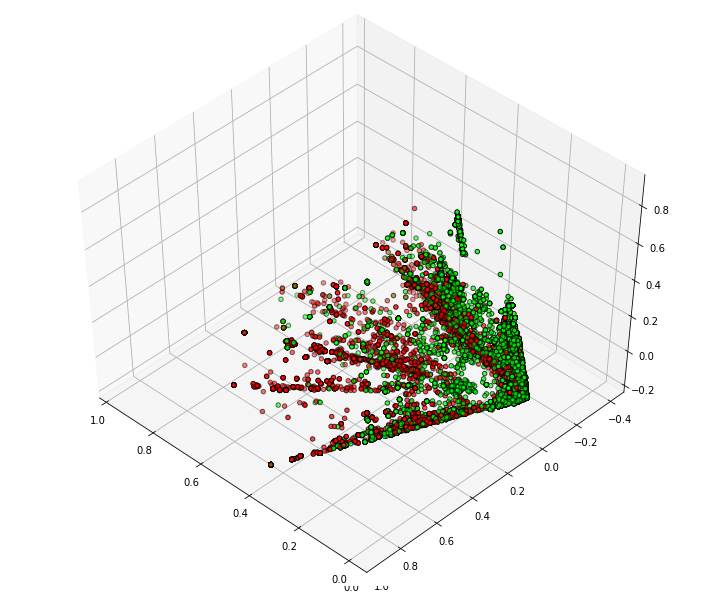

[('date', 0.13302147891359101), ('facture', 0.055491454161428776), ('client', 0.023731232769835405), ('paris', 0.022966846183758514), ('reglement', 0.010642315335834214), ('echeance', 0.0081255454908823223), ('total', 0.0079631731642266102), ('commande', 0.0072398475542899592), ('facturation', 0.006429142722023419), ('page', 0.0061686813258190571), ('emission', 0.0057909363079003866), ('description', 0.0056279877067741818), ('detail', 0.0050296820069961785), ('rue', 0.004586452566175821), ('paiement', 0.0044034119126458203), ('li', 0.004194631017625689), ('fa', 0.0041919845362509449), ('creation', 0.0039680353871118781), ('mode', 0.0039027377498986834), ('reference', 0.0037754562038393911), ('livraison', 0.0037625471019343362), ('invoice', 0.0037418439644490093), ('cl', 0.0037274386976747639), ('voici', 0.0036708730215888386), ('due', 0.003575517342054533), ('tel', 0.0035319470108835863), ('carte', 0.0034712985731713561), ('virement', 0.0033324618402833391), ('concierge', 0.00328675774

In [33]:


dir_name = os.path.dirname('__file__')
file_location= os.path.join(dir_name, 'dates_data_final.pickle')
file_object = pickle.load(open(file_location, 'rb'))

test = ProjectFDC(file_object)
test.cleanData(stem = False)
test.trainTest(perc = 0.25, set_data = 3, subsample = False)
test.termMatrix(stop_words = True, nbr = 15000) #nbr = 25323
test.visualisation(data = test.X_freq_train, target = test.train_target)
test.termMatrix(stop_words = False, freq = test.freqs, nbr = 5000)
#test.visualisation(data = test.X_freq_train, target = test.train_target)

### Benchmark of existant classifier algorithme (quick look)
<hr style="border-width:2px;border-color:#3CB371">

#### Benchmark Algorithme (existant in scikit-learn module)
* RidgeClassifier
* Perceptron
* KNeighborsClassifier
* SGDClassifier
* MultinomialNB
* BernoulliNB
* RandomForestClassifier
* PassiveAggressiveClassifier

__Ccl__: algorithmes choose for passing next step (FN < 1000) subsampling had been test and confirm this assumption.
* RidgeClassifier
* KNeighborsClassifier (delete  because take too much time for predecting)
* SGDClassifier
* RandomForestClassifier

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


train time: 0.236s
test time:  0.001s
accuracy:   0.886
classification report:
             precision    recall  f1-score   support

      False       0.90      0.95      0.93     16036
       True       0.83      0.69      0.75      5294

avg / total       0.88      0.89      0.88     21330

confusion matrix:
[[15268   768]
 [ 1666  3628]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.180s
test time:  0.001s
accuracy:   0.843
classification report:
             precision    recall  f1-score   support

      False       0.89      0.90      0.90     16036
       True       0.69      0.68      0.68      5294

avg / total       0.84      0.84      0.84     21330

confusion matrix:
[[14394  1642]
 [ 1716  3578]]

kNN
_________________________

//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


train time: 73.432s
test time:  4.018s
accuracy:   0.918
classification report:
             precision    recall  f1-score   support

      False       0.93      0.97      0.95     16036
       True       0.89      0.77      0.82      5294

avg / total       0.92      0.92      0.92     21330

confusion matrix:
[[15515   521]
 [ 1236  4058]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
train time: 0.214s
test time:  0.001s
accuracy:   0.878
classification report:
             precision    recall  f1-score   support

      False       0.89      0.95      0.92     16036
       True       0.81      0.66      0.73      5294

avg / total       0.87      0.88      0.87     21330

confusion matrix:
[[15242   794]
 [ 1806  3488]]



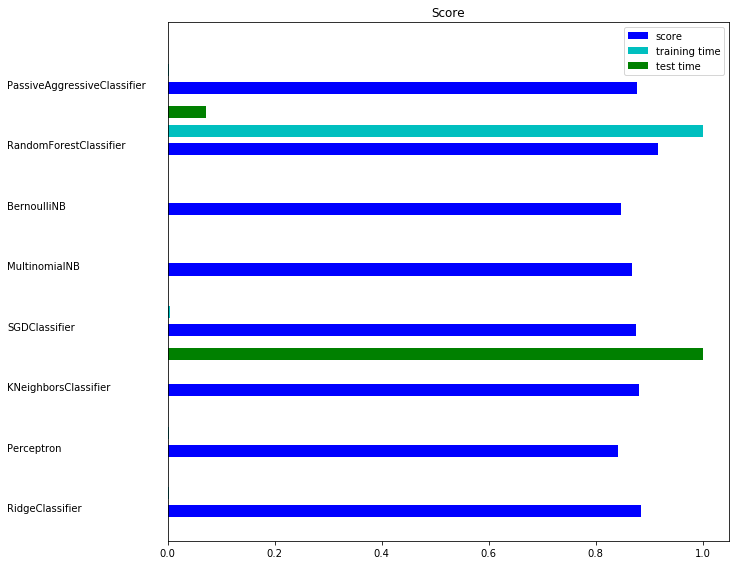

In [34]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet"), "SGD"),
        (MultinomialNB(alpha=.0), "Multi Naive Bayes"),
        (BernoulliNB(alpha=.0), "Bernoulli Naive Bayes"),
        (RandomForestClassifier(n_estimators=100), "Random forest"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        ):
    print('=' * 80)
    print(name)
    results.append(test.benchmark(clf,3))      
    

    

###################################################### make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='b')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='g')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()


### Visualyze learning
<hr style="border-width:2px;border-color:#3CB371">

* have kept only 5000 words allow to reduce overfitting
* The scores are good enough so we can conclude we don't have pverfitting

In [27]:
#Plot learning Curve 

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
cv_1 = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

Automatically created module for IPython interactive environment


//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
//anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) 

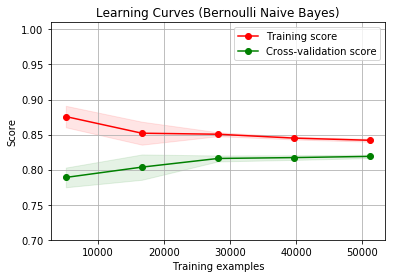

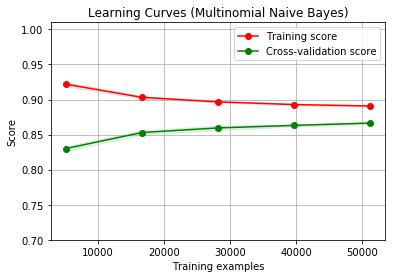

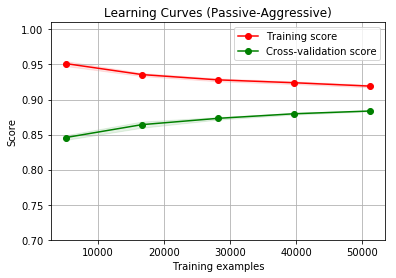

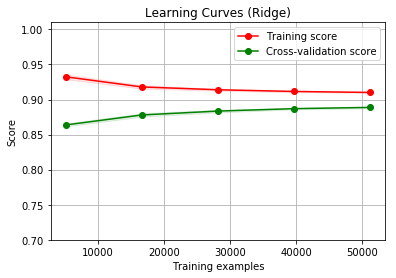

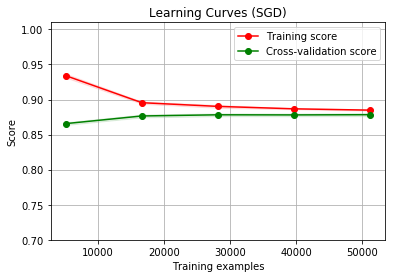

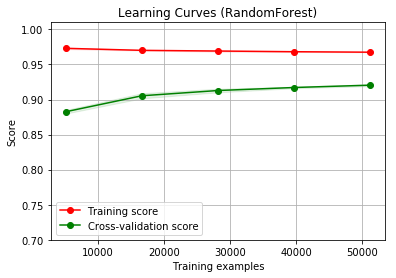

In [28]:



estimator_1 = BernoulliNB(alpha=.0)
plot_learning_curve(estimator_1, "Learning Curves (Bernoulli Naive Bayes)", test.X_tfidf_train, test.train_target, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

estimator_2 = MultinomialNB(alpha=.0)
plot_learning_curve(estimator_2, "Learning Curves (Multinomial Naive Bayes)", test.X_tfidf_train, test.train_target, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

estimator_3 = PassiveAggressiveClassifier(n_iter=50)
plot_learning_curve(estimator_3, "Learning Curves (Passive-Aggressive)", test.X_tfidf_train, test.train_target, ylim=(0.7, 1.01), cv=cv_1, n_jobs=4)

estimator_4 = RidgeClassifier(tol=1e-2, solver="lsqr")
plot_learning_curve(estimator_4, "Learning Curves (Ridge)", test.X_tfidf_train, test.train_target, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

estimator_5 = SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet")
plot_learning_curve(estimator_5, "Learning Curves (SGD)", test.X_tfidf_train, test.train_target, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

estimator_6 = RandomForestClassifier(n_estimators=100)
plot_learning_curve(estimator_6, "Learning Curves (RandomForest)", test.X_tfidf_train, test.train_target, ylim=(0.7, 1.01), cv=cv_1, n_jobs=4)

plt.show()

### tuning of best algorithme
<hr style="border-width:2px;border-color:#3CB371">
Tunning for finding best hyperparameters
* Random_Forest : ````RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_leaf=1,
bootstrap=False,max_features=100,max_depth=None,min_samples_split=10)````
<hr>
* SGD : ````SGDClassifier(estimator_5, "Learning Curves (SGD)", test.X_tfidf_train, test.train_target, ylim=(0.7, 1.01), cv=cv, n_jobs=4)````
<hr>
* Ridge : ````RidgeClassifier(class_weight = None, alpha = 1, solver = 'auto')````

__Ccl__ : finaly RandomForest outperform the other

                           

In [ ]:
# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [28]:
#Grid search for Ridge Classifier
clf = RidgeClassifier(tol=1e-2)

param_grid = {"alpha": [.000001, .00001, .0001, .001, .01, .1, 1, 10],
              "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
              "class_weight": [None, 'balanced']}
                         
# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(test.X_tfidf_train, test.train_target)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept w

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept w

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept w

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept w

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept w

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept w

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept w

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept w

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept w

GridSearchCV took 125.96 seconds for 112 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.885 (std: 0.001)
Parameters: {'class_weight': None, 'alpha': 1, 'solver': 'auto'}

Model with rank: 1
Mean validation score: 0.885 (std: 0.001)
Parameters: {'class_weight': None, 'alpha': 1, 'solver': 'lsqr'}

Model with rank: 3
Mean validation score: 0.885 (std: 0.001)
Parameters: {'class_weight': None, 'alpha': 1, 'solver': 'saga'}

Model with rank: 4
Mean validation score: 0.885 (std: 0.001)
Parameters: {'class_weight': None, 'alpha': 1, 'solver': 'svd'}

Model with rank: 4
Mean validation score: 0.885 (std: 0.001)
Parameters: {'class_weight': None, 'alpha': 1, 'solver': 'sag'}

Model with rank: 6
Mean validation score: 0.885 (std: 0.001)
Parameters: {'class_weight': None, 'alpha': 1, 'solver': 'cholesky'}

Model with rank: 7
Mean validation score: 0.885 (std: 0.001)
Parameters: {'class_weight': None, 'alpha': 1, 'solver': 'sparse_cg'}

Model with rank: 8
Mean validatio

In [21]:
#Grid search for SGD
clf = SGDClassifier(n_iter=50)

param_grid = {"loss": ['hinge', 'log', 'modified_huber', 'squared_hinge'],
              "penalty": ["l2","l1", "elasticnet"],
              "alpha": [.000001, .00001, .0001, .001, .01, .1, 1, 10]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(test.X_tfidf_train, test.train_target)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


GridSearchCV took 62.64 seconds for 96 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.887 (std: 0.001)
Parameters: {'loss': 'hinge', 'alpha': 1e-05, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.887 (std: 0.001)
Parameters: {'loss': 'hinge', 'alpha': 1e-05, 'penalty': 'elasticnet'}

Model with rank: 3
Mean validation score: 0.886 (std: 0.001)
Parameters: {'loss': 'hinge', 'alpha': 1e-05, 'penalty': 'l1'}

Model with rank: 4
Mean validation score: 0.884 (std: 0.001)
Parameters: {'loss': 'modified_huber', 'alpha': 0.0001, 'penalty': 'l2'}

Model with rank: 5
Mean validation score: 0.884 (std: 0.001)
Parameters: {'loss': 'log', 'alpha': 1e-05, 'penalty': 'elasticnet'}

Model with rank: 6
Mean validation score: 0.884 (std: 0.001)
Parameters: {'loss': 'log', 'alpha': 1e-05, 'penalty': 'l2'}

Model with rank: 7
Mean validation score: 0.884 (std: 0.001)
Parameters: {'loss': 'log', 'alpha': 1e-05, 'penalty': 'l1'}

Model with rank: 8
Mean validation s

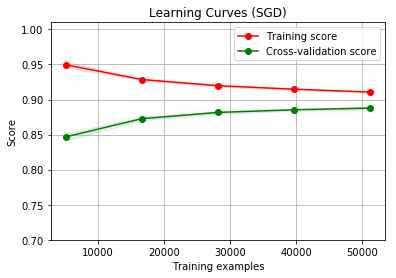

In [24]:
estimator_5 = SGDClassifier(loss = 'hinge', alpha=.00001, n_iter=50, penalty="elasticnet")
plot_learning_curve(estimator_5, "Learning Curves (SGD)", test.X_tfidf_train, test.train_target, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()


In [51]:
#Grid search for random forest
clf = RandomForestClassifier(n_estimators=10)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [10, 100, 1000],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1],
              "bootstrap": [ False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(test.X_tfidf_train, test.train_target)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 36730.39 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.917 (std: 0.001)
Parameters: {'criterion': 'entropy', 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 100, 'max_depth': None, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.916 (std: 0.001)
Parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 1000, 'max_depth': None, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.916 (std: 0.002)
Parameters: {'criterion': 'entropy', 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 1000, 'max_depth': None, 'min_samples_split': 10}

Model with rank: 4
Mean validation score: 0.915 (std: 0.000)
Parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 100, 'max_depth': None, 'min_samples_split': 10}

Model with rank: 5
Mean validation score: 0.915 (std: 0.002)
Parameters: {'criterion': 'gini', 'min_samp

<img src = "gridSearch.png" width=700px>

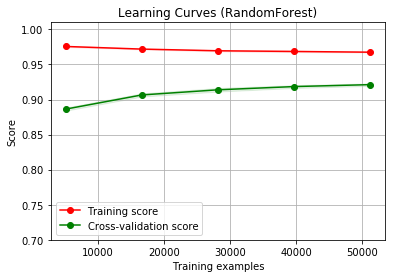

In [38]:
estimator_6 = RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_leaf=1,
                                     bootstrap=False,max_features=100,max_depth=None,min_samples_split=10)
plot_learning_curve(estimator_6, "Learning Curves (RandomForest)", test.X_tfidf_train, test.train_target, ylim=(0.7, 1.01), cv=cv_1, n_jobs=4)

plt.show()

### ROC curve metrics 
<hr style="border-width:2px;border-color:#3CB371">

* Used for evaluating prediction
* Used for finding optimal cut-off (true positive rate is high and the false positive rate is low.)


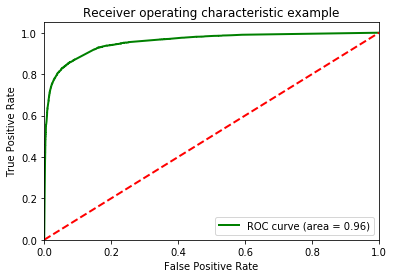

accuracy:   0.922
classification report:
             precision    recall  f1-score   support

      False       0.93      0.97      0.95     16036
       True       0.89      0.78      0.83      5294

avg / total       0.92      0.92      0.92     21330

confusion matrix:
[[15520   516]
 [ 1157  4137]]
[0.19112301587301556]


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [29]:
# Compute ROC curve and ROC area for each class

clf = RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_leaf=1,
                             bootstrap=False,max_features=100,max_depth=None,min_samples_split=10)

clf.fit(test.X_tfidf_train, test.train_target)

y_score_prob = clf.predict_proba(test.X_tfidf_test)
y_score = clf.predict(test.X_tfidf_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

fpr["micro"], tpr["micro"], _ = roc_curve(test.test_target, y_score_prob[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='g',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='r', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

score = metrics.accuracy_score(test.test_target, y_score)
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(test.test_target, y_score))

print("confusion matrix:")
print(metrics.confusion_matrix(test.test_target, y_score))




def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(test.test_target, y_score_prob[:,1])


print( threshold )

#### Add number of time that date appear in one doc

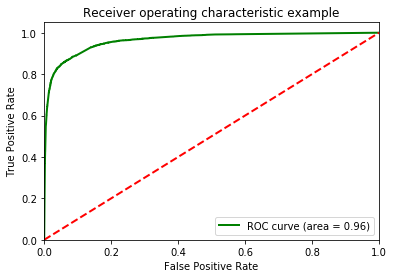

accuracy:   0.929
classification report:
             precision    recall  f1-score   support

      False       0.94      0.97      0.95     16036
       True       0.90      0.81      0.85      5294

avg / total       0.93      0.93      0.93     21330

confusion matrix:
[[15541   495]
 [ 1021  4273]]


In [30]:
from scipy.sparse import coo_matrix, hstack

B = np.asarray(test.count_train)
trainData = hstack([test.X_tfidf_train , B[:,None]])

C = np.asarray(test.count_test)
testData = hstack([test.X_tfidf_test , C[:,None]])

clf = RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_leaf=1,
                             bootstrap=False,max_features=100,max_depth=None,min_samples_split=10)

clf.fit(trainData, test.train_target)

y_score_prob_1 = clf.predict_proba(testData)
y_score_1 = clf.predict(testData)

fpr = dict()
tpr = dict()
roc_auc = dict()

fpr["micro"], tpr["micro"], _ = roc_curve(test.test_target, y_score_prob_1[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='g',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='r', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

score = metrics.accuracy_score(test.test_target, y_score_1)
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(test.test_target, y_score_1))

print("confusion matrix:")
print(metrics.confusion_matrix(test.test_target, y_score_1))

# Amelioration

* Create function fit & predict
* Only one date by id is relevant just take that are more probabilistic
* Find better stemming 
* Try other subsambling (SMOTE, oversample, ...)
* Try LSTM with this schema : <img src = "tf-graph.png" width=300px>
